# Creating an Expected Goals Map 

In the current notebook we go through the process of retrieving data from the Statsbomb API in order to extract information regarding all the shots made in all the women's matches shared by Statsbomb and later on train a model in order to calculate the expected goals of every shot. This model will allow us to explain how close came a team to win a particular match or whether a team is overperforming throughout the current season

In [1]:
#!pip install statsbombpy
#!pip install mplsoccer

In [2]:
from statsbombpy import sb
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from highlight_text import fig_text
import matplotlib as mpl
from mplsoccer.pitch import Pitch

#Set general use colors
text_color = 'w'

In [3]:
#Load data from Statsbomb API and select certain information

#Select information relateD to shots depending on its location and outcome
columns = ['team','type','location','shot_type','shot_outcome']
PRO = pd.DataFrame(columns=columns) #Create dataset for later on gather all womens matches data

#Select data from women's football competitions
df = sb.competitions()
df = df.loc[df['competition_gender'] == "female"].reset_index()

credentials were not supplied. open data access only


In [4]:
#Loop over every women's match and extract information
#wo_comp = women's football competition
#ma_sea = women's football match from certain competition
#wo_ma = women's football match

for z in range(len(df)):
    wom_comp = df.iloc[[z]]
    ma_sea = sb.matches(competition_id=wom_comp['competition_id'].values[0],season_id=wom_comp['season_id'].values[0])
    for t in range(len(ma_sea)):
        wo_ma = ma_sea.iloc[[t]]
        match = sb.events(match_id=wo_ma['match_id'].values[0])
        match = match[['team','type','location','shot_type','shot_outcome']].reset_index()
        match = match[match['type']=='Shot']
        PRO = PRO.append(match)

credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data access only
credentials were not supplied. open data acces

In [5]:
#Preview data

PRO

,team,type,location,shot_type,shot_outcome,index
2629,Liverpool WFC,Shot,"[108.9, 52.3]",Open Play,Off T,2629.0
2630,Brighton & Hove Albion WFC,Shot,"[86.5, 56.2]",Open Play,Saved,2630.0
2631,Liverpool WFC,Shot,"[115.7, 39.1]",Open Play,Off T,2631.0
2632,Liverpool WFC,Shot,"[113.3, 45.4]",Open Play,Off T,2632.0
2633,Liverpool WFC,Shot,"[93.0, 21.3]",Open Play,Off T,2633.0
...,...,...,...,...,...,...
4081,Sweden Women's,Shot,"[110.0, 43.8]",Open Play,Blocked,4081.0
4082,Netherlands Women's,Shot,"[107.3, 57.6]",Open Play,Off T,4082.0
4083,Netherlands Women's,Shot,"[113.3, 34.3]",Open Play,Off T,4083.0
4084,Sweden Women's,Shot,"[102.3, 39.9]",Open Play,Blocked,4084.0


In [6]:
#Cleaning Data

#Create coordinates variable
PRO["X"] = ""
PRO["Y"] = ""

#Split location variable into coordinates X and Y
for value in range(len(PRO['location'])):
    PRO['X'].iloc[value] = PRO['location'].iloc[value][0]
    PRO['Y'].iloc[value] = PRO['location'].iloc[value][1]
del PRO['location']



#Make that the coordinate variables are numeric
PRO['X']=pd.to_numeric(PRO['X'])
PRO['Y']=pd.to_numeric(PRO['Y'])

C:\Users\Borja\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [7]:
PRO

,team,type,shot_type,shot_outcome,index,X,Y
2629,Liverpool WFC,Shot,Open Play,Off T,2629.0,108.9,52.3
2630,Brighton & Hove Albion WFC,Shot,Open Play,Saved,2630.0,86.5,56.2
2631,Liverpool WFC,Shot,Open Play,Off T,2631.0,115.7,39.1
2632,Liverpool WFC,Shot,Open Play,Off T,2632.0,113.3,45.4
2633,Liverpool WFC,Shot,Open Play,Off T,2633.0,93.0,21.3
...,...,...,...,...,...,...,...
4081,Sweden Women's,Shot,Open Play,Blocked,4081.0,110.0,43.8
4082,Netherlands Women's,Shot,Open Play,Off T,4082.0,107.3,57.6
4083,Netherlands Women's,Shot,Open Play,Off T,4083.0,113.3,34.3
4084,Sweden Women's,Shot,Open Play,Blocked,4084.0,102.3,39.9


Once we loaded correctly the data we can visualize it. In the following plot you can see where the shots from open play came from. As you can notice most of the shots came from the center, where you may expect is most likely to score as you enjoy a greater angle. The distance is as well an important factor, the closer you get less time for the goalkeeper to react and then avoid a goal.

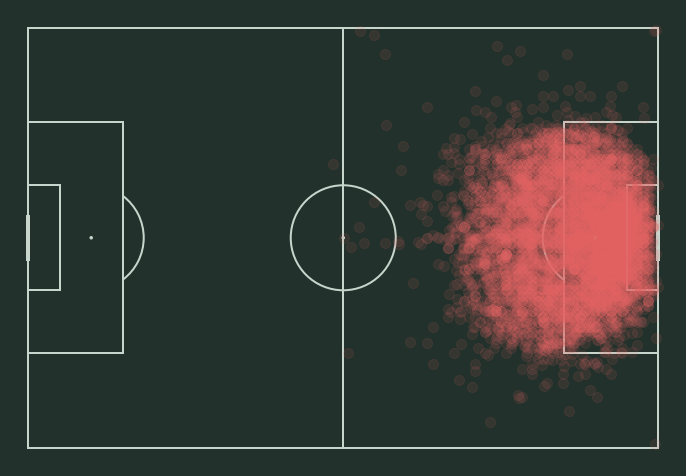

In [8]:
#Plot all the shots 

fig, ax = plt.subplots(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

#The statsbomb pitch from mplsoccer
pitch = Pitch(pitch_type='statsbomb', orientation='vertical',
              pitch_color='#22312b', line_color='#c7d5cc', figsize=(13, 8),
              constrained_layout=False, tight_layout=True, view='half')

pitch.draw(ax=ax)

#I invert the axis to make it so I am viewing it how I want
plt.gca().invert_yaxis()

#plot the points, you can use a for loop to plot the different outcomes if you want
plt.scatter(PRO['X'],PRO['Y'], s=100,c='#ea6969',alpha=.1)

Now you can check where the goals actually came from. Most of the goals came from shots inside the box. The further you getfrom the box the chances of scoring gets reduced. 

There are a few outliers that desereve to draw our attention. Those shots from the corner or quite cornered probably belong to a corner kick or a free kick and do not really have any relation to distance and angle, probably were goals condicioned by a mistake from the keeper. So we better select only goals that came from an open play (which is actually the most common scenario)

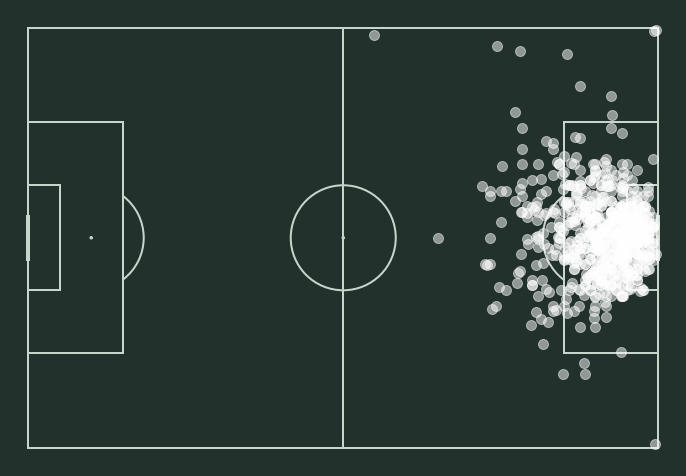

In [9]:
#Plot shots that ended up being a goal

fig, ax = plt.subplots(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

#The statsbomb pitch from mplsoccer
pitch = Pitch(pitch_type='statsbomb', orientation='vertical',
              pitch_color='#22312b', line_color='#c7d5cc', figsize=(13, 8),
              constrained_layout=False, tight_layout=True, view='half')

pitch.draw(ax=ax)

#I invert the axis to make it so I am viewing it how I want
plt.gca().invert_yaxis()

PRO2 = PRO[PRO['shot_outcome']=='Goal']


#plot the points, you can use a for loop to plot the different outcomes if you want
plt.scatter(PRO2['X'],PRO2['Y'], s=100,color='white',alpha=.5)

Now, we calculate the angle and the distance where the shots came from. Furthermore, we restrain the sample to shots that came from an open play


In [10]:
#Obtain distance and angle of every shot

PRO['Distance_X']=120-PRO['X']
PRO['Distance_Y']=abs(40-PRO['Y'])



x=PRO['Distance_X']*105/100
y=PRO['Distance_Y']*65/100
PRO['Distance']=np.sqrt(x**2 + y**2)

a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))

a[a < 0] = np.pi+a 


PRO['Angle']=a

#Keep only shots form open play 
PRO = PRO[PRO['shot_type']=='Open Play']
PRO.shot_type.unique()

array(['Open Play'], dtype=object)

In [11]:
#Create a Dummy variable of whether the shot actually became a goal
PRO = pd.get_dummies(PRO, columns=['shot_outcome'])


PRO = PRO.rename(columns={'shot_outcome_Goal': 'Goal'})

Shots = PRO[["Distance", "Angle","Goal"]]



Now, in order to be able to call whether a shot had greater or lower chances of becoming a goal we will use a logistic regression as our data is binomial, the dependent variable will be a Dummy indicating whether the shot was goal or not. We will take the angle and distance to the goal line as the variables in order to explain the chance of every shot of becoming goal.

As you can find out in the model both variables are significative. There are many variables that may influence the results and may hide in the error term. However due to several restrictions in the dataset (e.g. position of the defensive players of th eopposite team) or the lack of feasibility to asses whether a player is good enough with her weak foot, we better stick to this type of model as it is enough explanatory and we avoid a poor performance due to overfitting.

In [12]:
test_model = smf.glm(formula="Goal ~ Angle + Distance" , data=Shots, 
                           family=sm.families.Binomial()).fit()
print(test_model.summary())        
b=test_model.params

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   Goal   No. Observations:                 7077
Model:                            GLM   Df Residuals:                     7074
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2108.2
Date:                Thu, 06 May 2021   Deviance:                       4216.4
Time:                        20:46:47   Pearson chi2:                 6.94e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0549      0.215     -9.577      0.0

Now, we can plot our results. We can see how the wider the angle, the greater are the chances of scoring

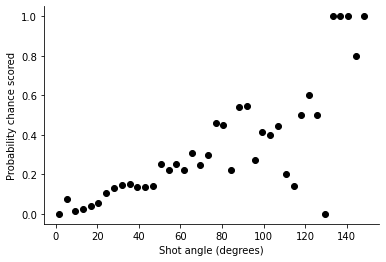

In [17]:
shots_model = Shots
goals_only = Shots[Shots['Goal']==1]

#Show empirically how goal angle predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Angle']*180/np.pi,bins=40,range=[0, 150])
goalcount_dist=np.histogram(goals_only['Angle']*180/np.pi,bins=40,range=[0, 150])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
angle=shotcount_dist[1]
midangle= (angle[:-1] + angle[1:])/2
fig,ax=plt.subplots(num=2)
ax.plot(midangle, prob_goal, linestyle='none', marker= '.', markerSize= 12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Shot angle (degrees)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)





We can see, as you can expect, how the closer to the goal line greater are the chances of scoring

<ipython-input-14-46bd02fce1e8>:4: RuntimeWarning: invalid value encountered in true_divide
  prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])


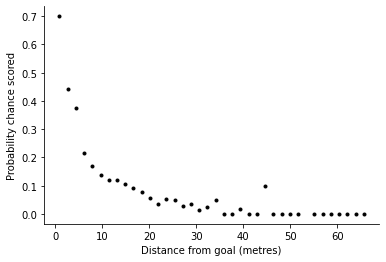

In [14]:
#Show empirically how distance from goal predicts probability of scoring
shotcount_dist=np.histogram(shots_model['Distance'],bins=40,range=[0, 70])
goalcount_dist=np.histogram(goals_only['Distance'],bins=40,range=[0, 70])
prob_goal=np.divide(goalcount_dist[0],shotcount_dist[0])
distance=shotcount_dist[1]
middistance= (distance[:-1] + distance[1:])/2
fig,ax=plt.subplots(num=1)
ax.plot(middistance, prob_goal, linestyle='none', marker= '.', color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel("Distance from goal (metres)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Finally we will generate a plot of the football pitch and color each squared meter depending on the chance of scoring from that part of the field.

As you may observe the chance of scoring is not that different if you shot from just outside the box compared to doing so from the midfield. The main reason is that in the latter situations a player will only shoot in very specific scenarios with great chanches of sending it to the net. For example when it's the aggregtae time and the goalkeeper goes to head a corner and can't return in time, or when the goalkeeper is caught way ahead of the goal line.

In [15]:
#Calculate the angle and distance from each part of the field to the goal line. We will use this data to retrieve the probability of scoring from each point

pgoal_2d=np.zeros((70,80))
for x in range(70):
    xz=x+50
    for y in range(80):
        
        sh = pd.DataFrame(columns=['X','Y','Penalty'])
        
        
        sh_x=120-xz
        sh_y=abs(40-y)



        xB=sh_x*105/100
        yB=sh_y*65/100
        sh_dist=np.sqrt(xB**2 + yB**2)

        a = np.arctan(7.32 *xB /(xB**2 + yB**2 - (7.32/2)**2))

        if a < 0:
            a=np.pi+a 

        sh_a=a
        
        
        columns = ["Distance", "Angle"]
        Results = pd.DataFrame([[sh_dist,sh_a]],columns=columns)
        
        pgoal_2d[x,y] = test_model.predict(Results)

pgoal_2d = pd.DataFrame(pgoal_2d)

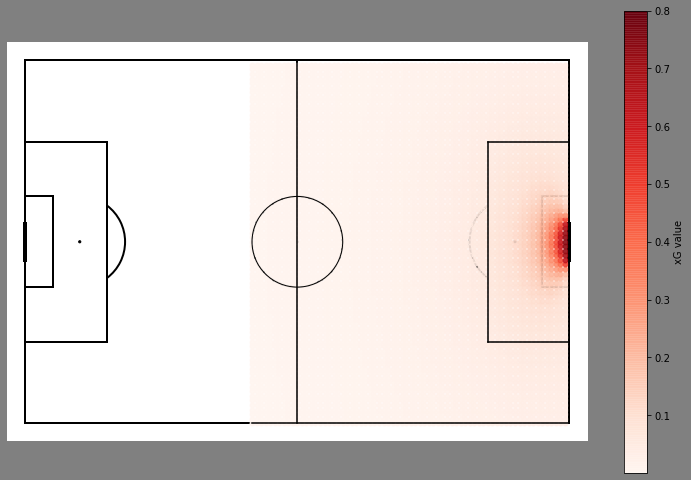

In [16]:
#Create a 2D map of xG

fig, ax = plt.subplots(figsize=(13,8.5))
fig.set_facecolor('#22312b')
ax.patch.set_facecolor('#22312b')

#The statsbomb pitch from mplsoccer
pitch = Pitch(pitch_type='statsbomb', orientation='vertical',
              pitch_color='white', line_color='black', figsize=(13, 8),
              constrained_layout=False, tight_layout=True, view='half')

pitch.draw(ax=ax)

#I invert the axis to make it so I am viewing it how I want
plt.gca().invert_yaxis()


#plot the points, you can use a for loop to plot the different outcomes if you want
for x in range(70):
    xz=x+50
    for y in range(80):
        plt.scatter(xz, y, s=24,alpha=.9,cmap=cm.Reds,c=pgoal_2d.iloc[x,y],vmin=0.00000001,vmax=0.8)


#Left Penalty Area
plt.plot([102,102],[62,18],color="black")
plt.plot([120,102],[62,62],color="black")
plt.plot([120,102],[18,18],color="black")

plt.plot([120,50],[80,80],color="black")
plt.plot([120,50],[0,0],color="black")
plt.plot([120,120],[0,80],color="black")

plt.plot([60,60],[0,80],color="black")

centreCircle = plt.Circle((60, 40), 10, color='black',fill=False)
ax.add_patch(centreCircle)

 

plt.colorbar(label="xG value", orientation="vertical")

fig.patch.set_facecolor('grey')

plt.show()